In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

## Strategy

### Phase 1
1. Load data
2. Visual data
3. Train with basic model
4. Plot history (accuracy, val_accuracy, loss, val_loss)
5. Test with camera

### Phase 2
1. Augment data
  - Shift
  - Rotate
2. Visual augmented data
3. Train with basic model
4. Plot history (accuracy, val_accuracy, loss, val_loss)
5. Train with more complicated architecture
6. Plot history (accuracy, val_accuracy, loss, val_loss)
7. Improve: Repeat from step 1
8. Test with camera

## Load data

The American Sign Language letter database of hand gestures represent a multi-class problem with 24 classes of letters (excluding J and Z which require motion).

In [2]:
df_train = pd.read_csv('dataset/train.csv')
df_test = pd.read_csv('dataset/test.csv')

## Visual data

In [3]:
df_train.head(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
print('Training set size: {}'.format(len(df_train)))
print('Test set size: {}'.format(len(df_test)))

Training set size: 27455
Test set size: 7172


In [5]:
df = pd.concat([df_train, df_test])

In [6]:
print('Total size: {}'.format(len(df)))

Total size: 34627


In [7]:
y = df['label'].values.reshape(-1, 1)
X = df.drop('label', axis=1).values.reshape(len(df), 28, 28)

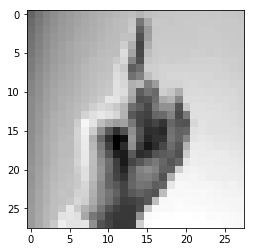

In [8]:
plt.imshow(X[0], cmap='gray')

In [9]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(y.reshape(-1, 1))
y_encoded = encoder.transform(y)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X.reshape(len(X), 28, 28, 1),
    y_encoded,
    test_size=0.2,
    random_state=40
)

## Train with basic model

It should be using padding

In [11]:
class BasicModel:
    @staticmethod
    def build(width, height, channels):
        model = Sequential([
            Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(height, width, channels)),
            Conv2D(32, (3, 3), padding='same', activation='relu'),
            MaxPool2D(pool_size=(2, 2)),
            
            Conv2D(64, (3, 3), padding='same', activation='relu'),
            Conv2D(64, (3, 3), padding='same', activation='relu'),
            MaxPool2D(pool_size=(2, 2)),
            
            Conv2D(128, (3, 3), padding='same', activation='relu'),
            Conv2D(128, (3, 3), padding='same', activation='relu'),
            Flatten(),
            
            Dense(1000, activation='relu'),
            Dense(24, activation='softmax'),
        ])
        model.build()
        return model

In [12]:
image_shape = X[0].shape

model = BasicModel.build(image_shape[1], image_shape[0], 1)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         7

In [13]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

In [14]:
BATCH_SIZE = 128
EPOCHS = 10

In [15]:
print(X_train.shape)
print(y_train.shape)

(27701, 28, 28, 1)
(27701, 24)


In [16]:
steps_per_epoch = len(X_train) / BATCH_SIZE
validation_steps = len(X_test) / BATCH_SIZE

history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    validation_data=(X_test, y_test)
)

Train on 27701 samples, validate on 6926 samples
Epoch 1/10
27701/27701 [==============================] - 18s 659us/sample - loss: 0.7341 - categorical_accuracy: 0.8268 - val_loss: 0.0054 - val_categorical_accuracy: 0.9991
Epoch 2/10
27701/27701 [==============================] - 7s 250us/sample - loss: 0.0203 - categorical_accuracy: 0.9953 - val_loss: 0.0022 - val_categorical_accuracy: 0.9994
Epoch 3/10
27701/27701 [==============================] - 7s 256us/sample - loss: 2.7527e-04 - categorical_accuracy: 1.0000 - val_loss: 2.9929e-05 - val_categorical_accuracy: 1.0000
Epoch 4/10
27701/27701 [==============================] - 7s 247us/sample - loss: 1.1547e-05 - categorical_accuracy: 1.0000 - val_loss: 1.8533e-05 - val_categorical_accuracy: 1.0000
Epoch 5/10
27701/27701 [==============================] - 7s 250us/sample - loss: 6.8981e-06 - categorical_accuracy: 1.0000 - val_loss: 1.3173e-05 - val_categorical_accuracy: 1.0000
Epoch 6/10
27701/27701 [==============================] 

In [17]:
model.save('basic_model.h5')

## Plot history

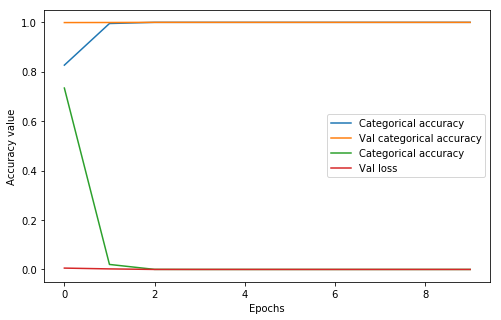

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(history.history['categorical_accuracy'], label='Categorical accuracy')
ax.plot(history.history['val_categorical_accuracy'], label='Val categorical accuracy')
ax.plot(history.history['loss'], label='Categorical accuracy')
ax.plot(history.history['val_loss'], label='Val loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy value')
ax.legend(loc='center right')
plt.show()